In [45]:
import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.cm as cm

# Configuration
DATA_DIR = "../data/extracted"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10          
BATCH_SIZE = 32
NUM_CLASSES = 14    

print(f"Working on {DEVICE}")

Working on cuda


# Helper Functions

In [46]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class TransformedDatasetWrapper(Dataset):
    """Wrapper to apply transforms to a Subset dynamically."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.subset)

# Data Loader with Ablation Support

In [47]:
def get_dataloaders(data_dir, use_aug=True, batch_size=32):
    """
    Creates dataloaders. 
    use_aug=True -> Applies data augmentation (Resize, Flip, Rotation, ColorJitter).
    use_aug=False -> Applies only Resize and Normalization (for ablation study).
    """
    # 1. Base Transforms 
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 2. Augmentation Transforms
    aug_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) if use_aug else base_transform

    # 3. Dataset & Splitting
    full_dataset = datasets.ImageFolder(root=data_dir)
    
    # Simple random split for experiments
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    generator = torch.Generator().manual_seed(42) # Ensure fixed split across experiments
    train_indices, val_indices, test_indices = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size], generator=generator
    )

    # 4. Wrap with correct transforms
    train_data = TransformedDatasetWrapper(train_indices, transform=aug_transform)
    test_data = TransformedDatasetWrapper(test_indices, transform=base_transform)
    val_data = TransformedDatasetWrapper(val_indices, transform=base_transform)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader, full_dataset.classes

# Experiments Main

In [48]:
def run_experiment(exp_name, model, optimizer, train_loader, val_loader, epochs):
    """
    Runs a training loop for a specific experiment configuration and tracks performance.
    """
    print(f"--- Starting Experiment: {exp_name} ---")
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    val_accs = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
    total_time = time.time() - start_time
    print(f"--- Finished {exp_name} in {total_time:.2f}s ---\n")
    
    return {
        "name": exp_name,
        "train_losses": train_losses,
        "val_accs": val_accs,
        "time": total_time
    }

# Experiment 1 - Optimizer Comparison (Adam vs SGD)

In [49]:
# Load Data
train_loader, val_loader, test_loader, class_names = get_dataloaders(DATA_DIR, use_aug=True)

# 1. Setup Adam
set_seed(42)
model_adam = models.resnet50(pretrained=True)
model_adam.fc = nn.Linear(model_adam.fc.in_features, NUM_CLASSES)
model_adam = model_adam.to(DEVICE)
opt_adam = optim.Adam(model_adam.parameters(), lr=0.0001)

res_adam = run_experiment("Optimizer_Adam", model_adam, opt_adam, train_loader, val_loader, EPOCHS)

# Cleanup memory
del model_adam, opt_adam
torch.cuda.empty_cache()

# 2. Setup SGD
set_seed(42)
model_sgd = models.resnet50(pretrained=True)
model_sgd.fc = nn.Linear(model_sgd.fc.in_features, NUM_CLASSES)
model_sgd = model_sgd.to(DEVICE)
opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.001, momentum=0.9) 

res_sgd = run_experiment("Optimizer_SGD", model_sgd, opt_sgd, train_loader, val_loader, EPOCHS)

c:\Users\PC1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--- Starting Experiment: Optimizer_Adam ---
Epoch 1/10 | Loss: 0.7150 | Val Acc: 99.36%
Epoch 2/10 | Loss: 0.0842 | Val Acc: 99.36%
Epoch 3/10 | Loss: 0.0352 | Val Acc: 99.68%
Epoch 4/10 | Loss: 0.0241 | Val Acc: 99.36%
Epoch 5/10 | Loss: 0.0283 | Val Acc: 98.09%
Epoch 6/10 | Loss: 0.0274 | Val Acc: 98.73%
Epoch 7/10 | Loss: 0.0098 | Val Acc: 99.68%
Epoch 8/10 | Loss: 0.0153 | Val Acc: 99.36%
Epoch 9/10 | Loss: 0.0239 | Val Acc: 99.04%
Epoch 10/10 | Loss: 0.0306 | Val Acc: 98.73%
--- Finished Optimizer_Adam in 57.98s ---

--- Starting Experiment: Optimizer_SGD ---
Epoch 1/10 | Loss: 2.0291 | Val Acc: 88.22%
Epoch 2/10 | Loss: 0.4667 | Val Acc: 99.36%
Epoch 3/10 | Loss: 0.1341 | Val Acc: 99.36%
Epoch 4/10 | Loss: 0.0830 | Val Acc: 99.36%
Epoch 5/10 | Loss: 0.0619 | Val Acc: 99.68%
Epoch 6/10 | Loss: 0.0448 | Val Acc: 99.68%
Epoch 7/10 | Loss: 0.0373 | Val Acc: 99.68%
Epoch 8/10 | Loss: 0.0257 | Val Acc: 99.68%
Epoch 9/10 | Loss: 0.0240 | Val Acc: 99.68%
Epoch 10/10 | Loss: 0.0213 | Val 

# Experiment 2 - Ablation Study (Impact of Data Augmentation)

In [50]:
# since we already have res_adam from the last experiment. We only need the model with no data augmentastion

train_loader_no_aug, val_loader_no_aug, test_loader_no_aug, class_names = get_dataloaders(DATA_DIR, use_aug=False)

set_seed(42)
model_no_aug = models.resnet50(pretrained=True)
model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, NUM_CLASSES)
model_no_aug = model_no_aug.to(DEVICE)
opt_no_aug = optim.Adam(model_no_aug.parameters(), lr=0.0001)

res_no_aug = run_experiment("No_Augmentation", model_no_aug, opt_no_aug, train_loader_no_aug, val_loader_no_aug, EPOCHS)

--- Starting Experiment: No_Augmentation ---
Epoch 1/10 | Loss: 0.6210 | Val Acc: 99.04%
Epoch 2/10 | Loss: 0.0342 | Val Acc: 99.68%
Epoch 3/10 | Loss: 0.0179 | Val Acc: 99.68%
Epoch 4/10 | Loss: 0.0167 | Val Acc: 99.68%
Epoch 5/10 | Loss: 0.0097 | Val Acc: 99.04%
Epoch 6/10 | Loss: 0.0044 | Val Acc: 99.68%
Epoch 7/10 | Loss: 0.0034 | Val Acc: 99.68%
Epoch 8/10 | Loss: 0.0108 | Val Acc: 99.04%
Epoch 9/10 | Loss: 0.0046 | Val Acc: 99.36%
Epoch 10/10 | Loss: 0.0017 | Val Acc: 99.68%
--- Finished No_Augmentation in 51.43s ---



# Experiment 3 - Statistical Test (Multiple Seeds)

In [51]:
seeds = [4, 8, 15, 16, 23, 42] 
seed_accuracies = []

print(f"--- Starting Statistical Test with {len(seeds)} seeds ---")

for seed in seeds:
    set_seed(seed)
    
    # Model Setup
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Train
    print(f"Running Seed {seed}...")
    # Using the standard loader (With augmentation)
    res = run_experiment(f"Seed_{seed}", model, optimizer, train_loader, val_loader, epochs=EPOCHS)
    
    # Capture final accuracy
    final_acc = res['val_accs'][-1]
    seed_accuracies.append(final_acc)
    
    del model, optimizer
    torch.cuda.empty_cache()

# Reporting
mean_acc = np.mean(seed_accuracies)
std_acc = np.std(seed_accuracies)

print(f"\nStatistical Results over {len(seeds)} runs:")
print(f"Accuracies: {seed_accuracies}")
print(f"Mean Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}")

--- Starting Statistical Test with 6 seeds ---
Running Seed 4...
--- Starting Experiment: Seed_4 ---
Epoch 1/10 | Loss: 0.7289 | Val Acc: 99.36%
Epoch 2/10 | Loss: 0.0498 | Val Acc: 99.68%
Epoch 3/10 | Loss: 0.0351 | Val Acc: 99.04%
Epoch 4/10 | Loss: 0.0567 | Val Acc: 99.68%
Epoch 5/10 | Loss: 0.0374 | Val Acc: 100.00%
Epoch 6/10 | Loss: 0.0261 | Val Acc: 100.00%
Epoch 7/10 | Loss: 0.0089 | Val Acc: 100.00%
Epoch 8/10 | Loss: 0.0122 | Val Acc: 100.00%
Epoch 9/10 | Loss: 0.0180 | Val Acc: 99.68%
Epoch 10/10 | Loss: 0.0126 | Val Acc: 99.68%
--- Finished Seed_4 in 58.97s ---

Running Seed 8...
--- Starting Experiment: Seed_8 ---
Epoch 1/10 | Loss: 0.7193 | Val Acc: 99.36%
Epoch 2/10 | Loss: 0.0649 | Val Acc: 99.36%
Epoch 3/10 | Loss: 0.0303 | Val Acc: 99.68%
Epoch 4/10 | Loss: 0.0316 | Val Acc: 98.73%
Epoch 5/10 | Loss: 0.0387 | Val Acc: 99.36%
Epoch 6/10 | Loss: 0.0238 | Val Acc: 99.68%
Epoch 7/10 | Loss: 0.0202 | Val Acc: 99.68%
Epoch 8/10 | Loss: 0.0182 | Val Acc: 99.68%
Epoch 9/10 | 

# Experiment 4 - Inference Timing

In [52]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)
model.eval()

# Dummy input for measurement
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

# Warmup for gpu
for _ in range(10):
    _ = model(dummy_input)

# Measure
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

start_event.record()
with torch.no_grad():
    for _ in range(100): # Process 100 images
        _ = model(dummy_input)
end_event.record()
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)
avg_time_per_img = elapsed_time_ms / 100

print(f"Inference Time per Image: {avg_time_per_img:.4f} ms")
print(f"FPS (Frames Per Second): {1000/avg_time_per_img:.2f}")

Inference Time per Image: 2.8366 ms
FPS (Frames Per Second): 352.53


# Experiment 5 - Feature Representation

Classes found: ['Bomb', 'Car', 'Casualty', 'Electricity', 'Fire', 'Fire_brigade', 'Flood', 'Gas', 'Injury', 'Paramedics', 'Person', 'Police', 'Road_block', 'Warning']
--- Extracting Features for Visualization ---
Feature shape: (315, 2048)
Running t-SNE... 


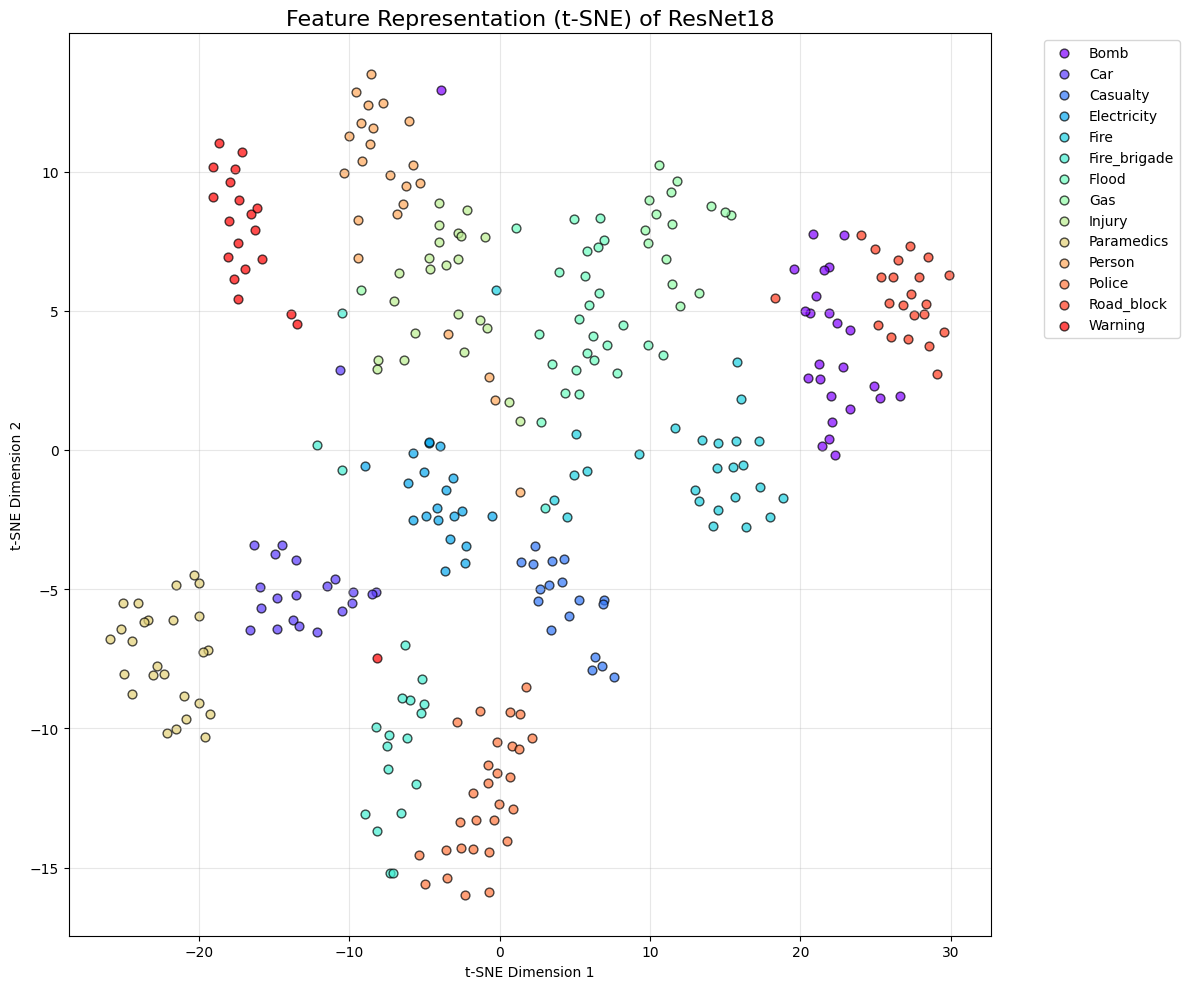

In [53]:
def visualize_feature_representation(model, dataloader, device, class_names):
    """
    Extracts features and visualizes them using t-SNE with actual class names.
    """
    print("--- Extracting Features for Visualization ---")
    
    # 1. Remove classification head
    feature_extractor = copy.deepcopy(model)
    feature_extractor.fc = nn.Identity() 
    feature_extractor.eval()
    
    features = []
    labels_list = []
    
    # 2. Extract features
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            output = feature_extractor(images)
            features.append(output.cpu().numpy())
            labels_list.append(labels.numpy())
            
    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels_list, axis=0)
    
    print(f"Feature shape: {X.shape}")
    print("Running t-SNE... ")
    
    # 3. Apply t-SNE (Removed n_iter to avoid TypeError)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X)
    
    # 4. Plotting
    plt.figure(figsize=(12, 10))
    
    unique_labels = np.unique(y)
    colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for label_idx, color in zip(unique_labels, colors):
        indices = y == label_idx
        
        # Get the actual string name for the class
        class_str = class_names[label_idx]
        
        plt.scatter(
            X_embedded[indices, 0], 
            X_embedded[indices, 1], 
            c=[color], 
            label=class_str, 
            alpha=0.7, 
            edgecolors='k',
            s=40
        )
        
    plt.title('Feature Representation (t-SNE) of ResNet18', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# We need to re-call this to capture the class names properly
_, _, test_loader, class_names = get_dataloaders(DATA_DIR, use_aug=False)

print(f"Classes found: {class_names}")

# 2. Run visualization with class names
visualize_feature_representation(model, test_loader, DEVICE, class_names)

# Visualization

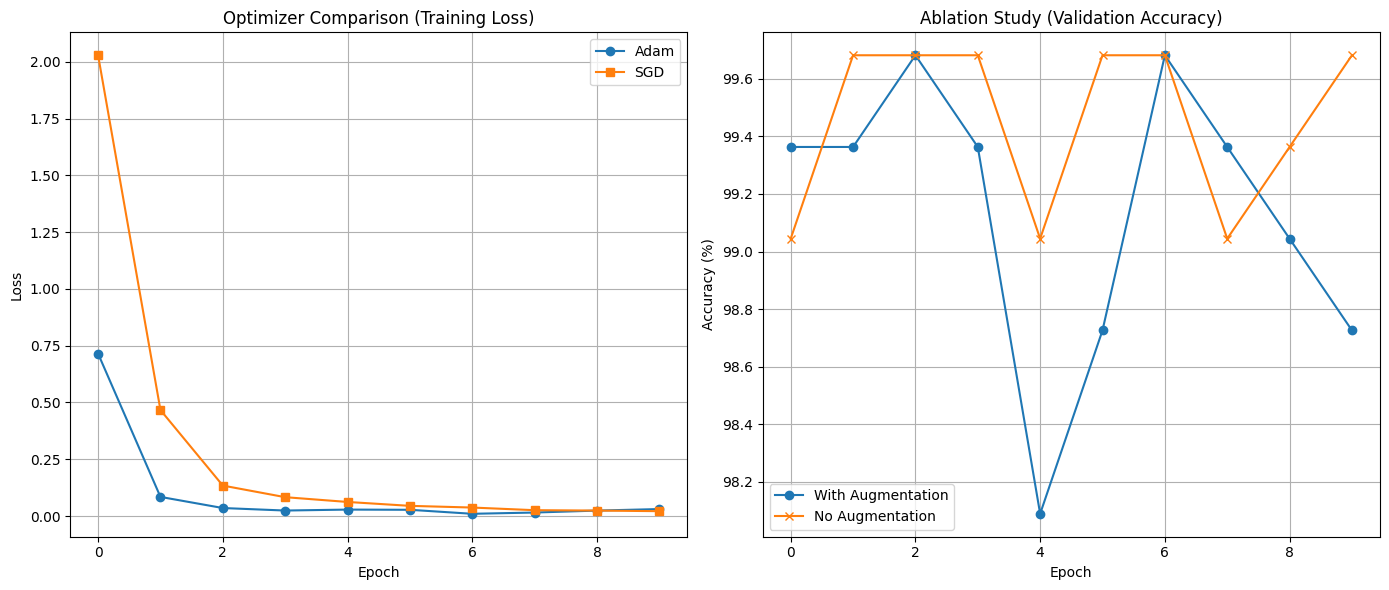

In [54]:
plt.figure(figsize=(14, 6))

# Plot 1: Optimizer Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(res_adam['train_losses'], label='Adam', marker='o')
plt.plot(res_sgd['train_losses'], label='SGD', marker='s')
plt.title('Optimizer Comparison (Training Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot 2: Ablation Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(res_adam['val_accs'], label='With Augmentation', marker='o')
plt.plot(res_no_aug['val_accs'], label='No Augmentation', marker='x')
plt.title('Ablation Study (Validation Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()